# Lenet MNIST

## Introduction
The model for which this IP designed for is follows. It has two convolutional layers with 16 and 32 neurons respectively. 
![Model Diagram](img/lenet_labelled.png)

The resource consumption of the model on PYNQ-Z1 is 
![Utilization](img/electric_slide.png)

## Runnning Hardware
This is how you can run the IP

In [1]:
from pynq import Overlay, allocate, PL
import numpy as np
import cffi
import os
import ctypes

data = '../data/lenet_bias/'

### IP driver
In PYNQ Linux, we need to write drivers for the IP ourselves. Following is a simple driver to initialize the parameters of the IP and run an image.

In [2]:
class nn_top_Driver:
    def __init__(self, bit_path=None):
        self.overlay = Overlay(bit_path)
        self.IP = self. overlay.nn_top_0
        self.reg = self.IP.register_map
        self.base_addr = self.IP.mmio.base_addr
        #Input and Output buffers
        self.input_buffer = None
        self.output_buffer = None
        

    def run(self):
        self.reg.CTRL.AP_START = 1
        while (not self.reg.CTRL.AP_DONE):
            pass
        
        
#   in_V_1 = Register(in_V=0),
#   in_V_2 = Register(in_V=0),
#   out_V_1 = Register(out_V=0),
#   out_V_2 = Register(out_V=0),
#   doInit = Register(doInit=0, RESERVED=0),
#   targetmem = Register(targetmem=0),
#   target_ch = Register(target_ch=0),
#   target_row = Register(target_row=0),
#   target_col = Register(target_col=0),
#   val_V_1 = Register(val_V=0),
#   val_V_2 = Register(val_V=0),
#   numReps = Register(numReps=0)

    def initialize(self, file, targetmem, CH, ROW, COL, isbias):
        
        if(isbias):
            array = np.loadtxt(file, dtype=ctypes.c_longlong, delimiter=',', usecols=[0])
        else:
            array = np.loadtxt(file, dtype=ctypes.c_uint32, delimiter=',',
                           usecols=[0],
                           converters={_:lambda s: int(s, 16) for _ in range(CH*ROW*COL)})

        array = array.reshape([CH, ROW, COL])
        print('Writing parameters...')
#         print(array)
        for ch in range(CH):
            for row in range(ROW):
                for col in range(COL):
#                   print('ch:{}, row:{}, col:{}'.format(str(ch), str(row), str(col)))
                    self.reg.doInit = 1
                    self.reg.targetmem = targetmem
                    self.reg.target_ch = ch
                    self.reg.target_row = row
                    self.reg.target_col = col
                    self.reg.numReps = 1
                    
                    if(isbias):
                        self.reg.val_V_1 = int(array[ch,row,col]) & (0xffffffff)
                        self.reg.val_V_2 = int(array[ch,row,col]) >> 32 & (0xffffffff)
                    else:    
                        self.reg.val_V_1 = (array[ch,row,col]) & (0xffffffff)
                        self.reg.val_V_2 = (array[ch,row,col]) >> 32 & (0xffffffff)
                    
                    # garbage vals
                    self.reg.in_V_1 = 0
                    self.reg.in_V_2 = 0
                    self.reg.out_V_1 = 0
                    self.reg.out_V_2 = 0
                    # Run IP
                    self.run()
                    self.reg.doInit = 0
    
    def set_io(self, file):
        in_shape = (28*28)//8 #due to 64 bit memory
        out_shape = 490
        
        image = np.loadtxt(file,
                           dtype=np.uint64, delimiter=',', usecols=[0],
                           converters={_:lambda s: int(s, 16) for _ in range(in_shape)})
        
        self.input_buffer = allocate(shape=in_shape, dtype=np.uint64)
        self.output_buffer = allocate(shape=out_shape, dtype=np.uint16)
        
        np.copyto(self.input_buffer, image)
        np.copyto(self.output_buffer, np.zeros(out_shape, dtype=np.uint16))
        
        self.reg.in_V_1 = self.input_buffer.physical_address & 0xffffffff
        self.reg.in_V_2 = (self.input_buffer.physical_address >> 32) & 0xffffffff
        self.reg.out_V_1 = (self.output_buffer.physical_address) & 0xffffffff
        self.reg.out_V_2 = (self.output_buffer.physical_address >> 32) & 0xffffffff
        self.reg.numReps = 1
        
        self.reg.doInit = 0
        self.reg.targetmem = 0
        self.reg.target_ch = 0
        self.reg.target_row = 0
        self.reg.target_col = 0
        self.reg.val_V_1 = 0
        self.reg.val_V_2 = 0
        print("Image Set. Ready to run")


In [3]:
nn_top_IP = nn_top_Driver('nn_top.bit')

In [4]:
from config import *


## Parameter Initializations

We need to  set the parameters of the network one by one externally. For this purpose,we call the initialize function of the driver. This is a time consuming process in PYNQ as python loops are more than a 100 times slower than C++

In [6]:
# Weight initializations
nn_top_IP.initialize(data +'conv1_packed_out4.txt', 1,OFM_CH_C1//out_parallel_C1,
                            IMG_CH//simd_C1, pe_num_C1, False)
nn_top_IP.initialize(data + 'conv2_packed_out2.txt', 3,OFM_CH_C2//out_parallel_C2,
                            OFM_CH_C1//simd_C2, pe_num_C2, False)


Writing parameters...
ch:0, row:0, col:0
ch:0, row:0, col:1
ch:0, row:0, col:2
ch:0, row:0, col:3
ch:0, row:0, col:4
ch:0, row:0, col:5
ch:0, row:0, col:6
ch:0, row:0, col:7
ch:0, row:0, col:8
ch:0, row:0, col:9
ch:0, row:0, col:10
ch:0, row:0, col:11
ch:0, row:0, col:12
ch:0, row:0, col:13
ch:0, row:0, col:14
ch:0, row:0, col:15
ch:0, row:0, col:16
ch:0, row:0, col:17
ch:0, row:0, col:18
ch:0, row:0, col:19
ch:0, row:0, col:20
ch:0, row:0, col:21
ch:0, row:0, col:22
ch:0, row:0, col:23
ch:0, row:0, col:24
ch:0, row:0, col:25
ch:0, row:0, col:26
ch:0, row:0, col:27
ch:0, row:0, col:28
ch:0, row:0, col:29
ch:0, row:0, col:30
ch:0, row:0, col:31
ch:0, row:0, col:32
ch:0, row:0, col:33
ch:0, row:0, col:34
ch:0, row:0, col:35
ch:0, row:0, col:36
ch:0, row:0, col:37
ch:0, row:0, col:38
ch:0, row:0, col:39
ch:0, row:0, col:40
ch:0, row:0, col:41
ch:0, row:0, col:42
ch:0, row:0, col:43
ch:0, row:0, col:44
ch:0, row:0, col:45
ch:0, row:0, col:46
ch:0, row:0, col:47
ch:0, row:0, col:48
ch:0, ro

ch:0, row:4, col:28
ch:0, row:4, col:29
ch:0, row:4, col:30
ch:0, row:4, col:31
ch:0, row:5, col:0
ch:0, row:5, col:1
ch:0, row:5, col:2
ch:0, row:5, col:3
ch:0, row:5, col:4
ch:0, row:5, col:5
ch:0, row:5, col:6
ch:0, row:5, col:7
ch:0, row:5, col:8
ch:0, row:5, col:9
ch:0, row:5, col:10
ch:0, row:5, col:11
ch:0, row:5, col:12
ch:0, row:5, col:13
ch:0, row:5, col:14
ch:0, row:5, col:15
ch:0, row:5, col:16
ch:0, row:5, col:17
ch:0, row:5, col:18
ch:0, row:5, col:19
ch:0, row:5, col:20
ch:0, row:5, col:21
ch:0, row:5, col:22
ch:0, row:5, col:23
ch:0, row:5, col:24
ch:0, row:5, col:25
ch:0, row:5, col:26
ch:0, row:5, col:27
ch:0, row:5, col:28
ch:0, row:5, col:29
ch:0, row:5, col:30
ch:0, row:5, col:31
ch:0, row:6, col:0
ch:0, row:6, col:1
ch:0, row:6, col:2
ch:0, row:6, col:3
ch:0, row:6, col:4
ch:0, row:6, col:5
ch:0, row:6, col:6
ch:0, row:6, col:7
ch:0, row:6, col:8
ch:0, row:6, col:9
ch:0, row:6, col:10
ch:0, row:6, col:11
ch:0, row:6, col:12
ch:0, row:6, col:13
ch:0, row:6, col:14


ch:2, row:2, col:5
ch:2, row:2, col:6
ch:2, row:2, col:7
ch:2, row:2, col:8
ch:2, row:2, col:9
ch:2, row:2, col:10
ch:2, row:2, col:11
ch:2, row:2, col:12
ch:2, row:2, col:13
ch:2, row:2, col:14
ch:2, row:2, col:15
ch:2, row:2, col:16
ch:2, row:2, col:17
ch:2, row:2, col:18
ch:2, row:2, col:19
ch:2, row:2, col:20
ch:2, row:2, col:21
ch:2, row:2, col:22
ch:2, row:2, col:23
ch:2, row:2, col:24
ch:2, row:2, col:25
ch:2, row:2, col:26
ch:2, row:2, col:27
ch:2, row:2, col:28
ch:2, row:2, col:29
ch:2, row:2, col:30
ch:2, row:2, col:31
ch:2, row:3, col:0
ch:2, row:3, col:1
ch:2, row:3, col:2
ch:2, row:3, col:3
ch:2, row:3, col:4
ch:2, row:3, col:5
ch:2, row:3, col:6
ch:2, row:3, col:7
ch:2, row:3, col:8
ch:2, row:3, col:9
ch:2, row:3, col:10
ch:2, row:3, col:11
ch:2, row:3, col:12
ch:2, row:3, col:13
ch:2, row:3, col:14
ch:2, row:3, col:15
ch:2, row:3, col:16
ch:2, row:3, col:17
ch:2, row:3, col:18
ch:2, row:3, col:19
ch:2, row:3, col:20
ch:2, row:3, col:21
ch:2, row:3, col:22
ch:2, row:3, co

ch:3, row:7, col:9
ch:3, row:7, col:10
ch:3, row:7, col:11
ch:3, row:7, col:12
ch:3, row:7, col:13
ch:3, row:7, col:14
ch:3, row:7, col:15
ch:3, row:7, col:16
ch:3, row:7, col:17
ch:3, row:7, col:18
ch:3, row:7, col:19
ch:3, row:7, col:20
ch:3, row:7, col:21
ch:3, row:7, col:22
ch:3, row:7, col:23
ch:3, row:7, col:24
ch:3, row:7, col:25
ch:3, row:7, col:26
ch:3, row:7, col:27
ch:3, row:7, col:28
ch:3, row:7, col:29
ch:3, row:7, col:30
ch:3, row:7, col:31
ch:4, row:0, col:0
ch:4, row:0, col:1
ch:4, row:0, col:2
ch:4, row:0, col:3
ch:4, row:0, col:4
ch:4, row:0, col:5
ch:4, row:0, col:6
ch:4, row:0, col:7
ch:4, row:0, col:8
ch:4, row:0, col:9
ch:4, row:0, col:10
ch:4, row:0, col:11
ch:4, row:0, col:12
ch:4, row:0, col:13
ch:4, row:0, col:14
ch:4, row:0, col:15
ch:4, row:0, col:16
ch:4, row:0, col:17
ch:4, row:0, col:18
ch:4, row:0, col:19
ch:4, row:0, col:20
ch:4, row:0, col:21
ch:4, row:0, col:22
ch:4, row:0, col:23
ch:4, row:0, col:24
ch:4, row:0, col:25
ch:4, row:0, col:26
ch:4, row:0

ch:5, row:4, col:12
ch:5, row:4, col:13
ch:5, row:4, col:14
ch:5, row:4, col:15
ch:5, row:4, col:16
ch:5, row:4, col:17
ch:5, row:4, col:18
ch:5, row:4, col:19
ch:5, row:4, col:20
ch:5, row:4, col:21
ch:5, row:4, col:22
ch:5, row:4, col:23
ch:5, row:4, col:24
ch:5, row:4, col:25
ch:5, row:4, col:26
ch:5, row:4, col:27
ch:5, row:4, col:28
ch:5, row:4, col:29
ch:5, row:4, col:30
ch:5, row:4, col:31
ch:5, row:5, col:0
ch:5, row:5, col:1
ch:5, row:5, col:2
ch:5, row:5, col:3
ch:5, row:5, col:4
ch:5, row:5, col:5
ch:5, row:5, col:6
ch:5, row:5, col:7
ch:5, row:5, col:8
ch:5, row:5, col:9
ch:5, row:5, col:10
ch:5, row:5, col:11
ch:5, row:5, col:12
ch:5, row:5, col:13
ch:5, row:5, col:14
ch:5, row:5, col:15
ch:5, row:5, col:16
ch:5, row:5, col:17
ch:5, row:5, col:18
ch:5, row:5, col:19
ch:5, row:5, col:20
ch:5, row:5, col:21
ch:5, row:5, col:22
ch:5, row:5, col:23
ch:5, row:5, col:24
ch:5, row:5, col:25
ch:5, row:5, col:26
ch:5, row:5, col:27
ch:5, row:5, col:28
ch:5, row:5, col:29
ch:5, row:

ch:7, row:1, col:14
ch:7, row:1, col:15
ch:7, row:1, col:16
ch:7, row:1, col:17
ch:7, row:1, col:18
ch:7, row:1, col:19
ch:7, row:1, col:20
ch:7, row:1, col:21
ch:7, row:1, col:22
ch:7, row:1, col:23
ch:7, row:1, col:24
ch:7, row:1, col:25
ch:7, row:1, col:26
ch:7, row:1, col:27
ch:7, row:1, col:28
ch:7, row:1, col:29
ch:7, row:1, col:30
ch:7, row:1, col:31
ch:7, row:2, col:0
ch:7, row:2, col:1
ch:7, row:2, col:2
ch:7, row:2, col:3
ch:7, row:2, col:4
ch:7, row:2, col:5
ch:7, row:2, col:6
ch:7, row:2, col:7
ch:7, row:2, col:8
ch:7, row:2, col:9
ch:7, row:2, col:10
ch:7, row:2, col:11
ch:7, row:2, col:12
ch:7, row:2, col:13
ch:7, row:2, col:14
ch:7, row:2, col:15
ch:7, row:2, col:16
ch:7, row:2, col:17
ch:7, row:2, col:18
ch:7, row:2, col:19
ch:7, row:2, col:20
ch:7, row:2, col:21
ch:7, row:2, col:22
ch:7, row:2, col:23
ch:7, row:2, col:24
ch:7, row:2, col:25
ch:7, row:2, col:26
ch:7, row:2, col:27
ch:7, row:2, col:28
ch:7, row:2, col:29
ch:7, row:2, col:30
ch:7, row:2, col:31
ch:7, row:

ch:8, row:6, col:15
ch:8, row:6, col:16
ch:8, row:6, col:17
ch:8, row:6, col:18
ch:8, row:6, col:19
ch:8, row:6, col:20
ch:8, row:6, col:21
ch:8, row:6, col:22
ch:8, row:6, col:23
ch:8, row:6, col:24
ch:8, row:6, col:25
ch:8, row:6, col:26
ch:8, row:6, col:27
ch:8, row:6, col:28
ch:8, row:6, col:29
ch:8, row:6, col:30
ch:8, row:6, col:31
ch:8, row:7, col:0
ch:8, row:7, col:1
ch:8, row:7, col:2
ch:8, row:7, col:3
ch:8, row:7, col:4
ch:8, row:7, col:5
ch:8, row:7, col:6
ch:8, row:7, col:7
ch:8, row:7, col:8
ch:8, row:7, col:9
ch:8, row:7, col:10
ch:8, row:7, col:11
ch:8, row:7, col:12
ch:8, row:7, col:13
ch:8, row:7, col:14
ch:8, row:7, col:15
ch:8, row:7, col:16
ch:8, row:7, col:17
ch:8, row:7, col:18
ch:8, row:7, col:19
ch:8, row:7, col:20
ch:8, row:7, col:21
ch:8, row:7, col:22
ch:8, row:7, col:23
ch:8, row:7, col:24
ch:8, row:7, col:25
ch:8, row:7, col:26
ch:8, row:7, col:27
ch:8, row:7, col:28
ch:8, row:7, col:29
ch:8, row:7, col:30
ch:8, row:7, col:31
ch:9, row:0, col:0
ch:9, row:0

In [5]:
# Bias initializations
nn_top_IP.initialize(data + 'qconv1_b.txt', 2, 1, OFM_CH_C1//out_parallel_C1,
                            out_parallel_C1, True)
nn_top_IP.initialize(data + 'qconv2_b.txt', 4, 1, OFM_CH_C2//out_parallel_C2,
                            out_parallel_C2, True)

Writing parameters...
ch:0, row:0, col:0
ch:0, row:0, col:1
ch:0, row:0, col:2
ch:0, row:0, col:3
ch:0, row:1, col:0
ch:0, row:1, col:1
ch:0, row:1, col:2
ch:0, row:1, col:3
ch:0, row:2, col:0
ch:0, row:2, col:1
ch:0, row:2, col:2
ch:0, row:2, col:3
ch:0, row:3, col:0
ch:0, row:3, col:1
ch:0, row:3, col:2
ch:0, row:3, col:3
Writing parameters...
ch:0, row:0, col:0
ch:0, row:0, col:1
ch:0, row:1, col:0
ch:0, row:1, col:1
ch:0, row:2, col:0
ch:0, row:2, col:1
ch:0, row:3, col:0
ch:0, row:3, col:1
ch:0, row:4, col:0
ch:0, row:4, col:1
ch:0, row:5, col:0
ch:0, row:5, col:1
ch:0, row:6, col:0
ch:0, row:6, col:1
ch:0, row:7, col:0
ch:0, row:7, col:1
ch:0, row:8, col:0
ch:0, row:8, col:1
ch:0, row:9, col:0
ch:0, row:9, col:1


## Setting up Input

(28, 28)


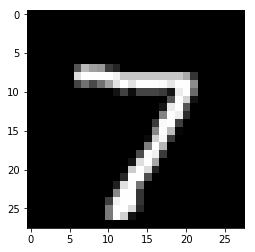

In [7]:
# Set input and output
import matplotlib.pyplot as plt
%matplotlib inline

image = np.zeros(shape=[28,28])
with open('../data/lenet_bias/input_image.txt', 'r') as current_file:
    for i, line in enumerate(current_file.readlines()):
        point = line.strip(',\n').split(',')
        image[:,i] = point
        
image = image.transpose([1,0])

# print(image.shape)
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

## Running IP

In [8]:
# Run input through IP
nn_top_IP.set_io('../data/lenet_bias/input_sdk.txt')
nn_top_IP.run()

Image Set. Ready to run


In [9]:
# Viewing the Output
# nn_top_IP.output_buffer
for i in range(len(nn_top_IP.output_buffer)):
    print(hex(nn_top_IP.output_buffer[i]))

0x1e
0x700
0x0
0x200
0x0
0xd00
0x961
0x8
0x900
0x0
0x1e
0x100
0x0
0x0
0x0
0x500
0x961
0x3
0x900
0x0
0x1e
0x100
0x0
0x0
0x0
0x500
0x961
0x3
0x900
0x0
0x1e
0x100
0x0
0x0
0x0
0x500
0x961
0x3
0x900
0x0
0x1e
0x100
0x0
0x0
0x0
0x500
0x961
0x3
0x900
0x0
0x1e
0x100
0x0
0x0
0x0
0x500
0x961
0x3
0x900
0x0
0x1e
0x100
0x1
0x0
0x1200
0x500
0x961
0x6
0x900
0x0
0x14
0x3216
0x0
0x3d00
0x0
0x4100
0x69
0x8
0x4400
0x0
0x69
0x6e
0x8cd1
0xb471
0x3331
0xff92
0xf0
0x0
0xffff
0x111c
0xff
0x15
0x7cff
0xed
0x6
0xffff
0xff
0x0
0xff
0x4a
0xfc
0x4a
0xff
0x9c
0x18
0xf07e
0x1de5
0x21
0xff
0xb
0xbe
0x53
0xff
0x60
0x10
0xf12c
0x24ff
0x20
0xff
0x0
0xdca
0x4e05
0xff
0x0
0x5f
0x5d14
0x22c4
0x1c
0xff
0x3500
0x42
0x1f00
0x13
0x0
0x1200
0x0
0x64
0x2
0x0
0x0
0x71
0x500c
0x0
0x3700
0x0
0xb00
0x2563
0x217
0x2200
0x0
0x10ff
0x50ab
0x0
0xffe3
0x5b
0x6aff
0xffa9
0xffff
0xc00
0x3524
0xff
0xc3
0x6b00
0xffff
0xaf
0xd9ff
0xff7c
0xffff
0xff
0xf8
0x90
0xff
0x1800
0xffff
0x82
0xffff
0xff00
0xffff
0xff
0x95
0x0
0xda
0x77ff
0xffff
0xd2
0xf

## Postprocessing on PS
We are running only the Convolutional layers on programmable logic as these contain a high degree of parallelism. The outputs of the conv layers are passed through fully connected layers on PS of SoC.

In [10]:
from ps_run import *

In [11]:
pred = run_fc_computer(nn_top_IP.output_buffer)

(500, 980) (980,)


## Result

In [12]:
print("Prediction = {}".format(np.argmax(pred)))

Prediction = 7
